# Some experiments in Gaussian Processes Regression
> Using GPy and some interactive visualisations for understanding GPR and applying on a real world data set

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

>youtube: https://www.youtube.com/watch?v=V1bF37-_ytQ

### Disclaimer

This blog post is forked from [GPSS 2019](http://gpss.cc/gpss19/) [Lab 1](https://nbviewer.jupyter.org/github/gpschool/labs/blob/2019/2019/.answers/lab_1.ipynb). This is produced only for educational purposes. All credit goes to the GPSS organisers. 

In [1]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy
from IPython.display import display


### Covariance functions, aka kernels

We will define a covariance function, from hereon referred to as a kernel, using `GPy`. The most commonly used kernel in machine learning is the Gaussian-form radial basis function (RBF) kernel. It is also commonly referred to as the exponentiated quadratic or squared exponential kernel &ndash; all are equivalent.

The definition of the (1-dimensional) RBF kernel has a Gaussian-form, defined as:

$$
    \kappa_\mathrm{rbf}(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\mathscr{l}^2}\right)
$$

It has two parameters, described as the variance, $\sigma^2$ and the lengthscale $\mathscr{l}$.

In GPy, we define our kernels using the input dimension as the first argument, in the simplest case `input_dim=1` for 1-dimensional regression. We can also explicitly define the parameters, but for now we will use the default values:

In [2]:
# Create a 1-D RBF kernel with default parameters
k = GPy.kern.RBF(1)
# Preview the kernel's parameters
k

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


We can see from the above table that our kernel has two parameters, `variance` and `lengthscale`, both with value `1.0`. There is also information on the constraints and priors on each parameter, but we will look at this later.

### Visualising the kernel

We can visualise our kernel in a few different ways. We can plot the _shape_ of the kernel by plotting $k(x,0)$ over some sample space $x$ which, looking at the equation above, clearly has a Gaussian shape. This describes the covariance between each sample location and $0$.

In [3]:
# Our sample space: 100 samples in the interval [-4,4]
X = np.linspace(-4.,4.,100)[:, None] # we need [:, None] to reshape X into a column vector for use in GPy

# First, sample kernel at x' = 0
K = k.K(X, np.array([[0.]])) # k(x,0)

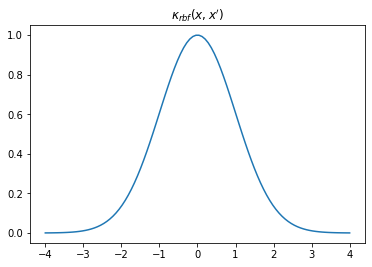

In [4]:
plt.plot(X, K)
plt.title("$\kappa_{rbf}(x,x')$");

Writing an animation function routine for visualsing kernel with changing length scale

In [5]:
fig, ax = plt.subplots()
from matplotlib.animation import FuncAnimation
from matplotlib import rc
ls = [0.05, 0.25, 0.5, 1., 2., 4.]



def update(iteration):
    ax.cla()
    k = GPy.kern.RBF(1)
    k.lengthscale = ls[iteration]
    # Calculate the new covariance function at k(x,0)
    C = k.K(X, np.array([[0.]]))
    # Plot the resulting covariance vector
    ax.plot(X,C)
    ax.set_title("$\kappa_{rbf}(x,x')$\nLength scale = %s" %k.lengthscale[0]);
    ax.set_ylim((0, 1.2))



num_iterations = len(ls)
anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations-1, 1), interval=500)
plt.close()

rc('animation', html='jshtml')
anim

From the animation above, we can notice that increasing the scale means that a point becomes more correlated with a further away point. Using such a kernel for GP regression and increasing the length scale would mean making the regression smoother.

Writing an animation function routine for visualsing kernel with changing variance

In [6]:
fig, ax = plt.subplots()
import os
from matplotlib.animation import FuncAnimation
from matplotlib import rc
variances = [0.01, 0.05, 0.25, 0.5, 1., 2., 4.]



def update(iteration):
    ax.cla()
    k = GPy.kern.RBF(1)
    k.variance = variances[iteration]
    # Calculate the new covariance function at k(x,0)
    C = k.K(X, np.array([[0.]]))
    # Plot the resulting covariance vector
    ax.plot(X,C)
    ax.set_title("$\kappa_{rbf}(x,x')$\nVariance = %s" %k.variance[0]);
    ax.set_ylim((0, 2))

num_iterations = len(ls)
anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations-1, 1), interval=500)
plt.close()

rc('animation', html='jshtml')
anim

Alternatively, we can construct a full covariance matrix, $\mathbf{K}_{xx} \triangleq k(x,x')$ with samples $x = x'$. The resulting GP prior is a multivariate normal distribution over the space of samples $x$: $\mathcal{N}(\mathbf{0}, \mathbf{K}_{xx})$. It should be evident then that the elements of the matrix represents the covariance between respective points in $x$ and $x'$, and that it is exactly $\sigma^2[=1]$ in the diagonal.


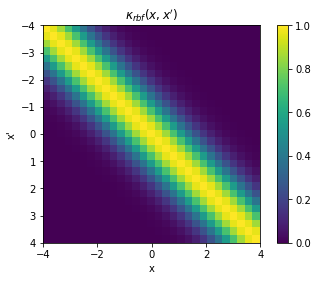

In [7]:
X = np.linspace(-4.,4.,30)[:, None]
K = k.K(X,X)

# Plot the covariance of the sample space
plt.pcolor(X.T, X, K)

# Format and annotate plot
plt.gca().invert_yaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("$\kappa_{rbf}(x,x')$");

In [8]:
fig, ax = plt.subplots()
cax = fig.add_axes([0.87, 0.2, 0.05, 0.65])



def update(iteration):
    ax.cla()
    cax.cla()
    k = GPy.kern.RBF(1)
    k.lengthscale = ls[iteration]
    # Calculate the new covariance function at k(x,0)
    K = k.K(X,X)

    # Plot the covariance of the sample space
    im = ax.pcolor(X.T, X, K)

    # Format and annotate plot
    ax.invert_yaxis()
    ax.axis("image")
    #ax.colorbar()
    # Plot the resulting covariance vector
    ax.set_title("Length scale = %s" %k.lengthscale[0]);
    #ax.set_ylim((0, 1.2))
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.tight_layout()



num_iterations = len(ls)
anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations, 1), interval=500)
plt.close()

rc('animation', html='jshtml')
anim

The above animation shows the impact of increasing length scale on the covariance matrix.

In [9]:
fig, ax = plt.subplots()
cax = fig.add_axes([0.87, 0.2, 0.05, 0.65])



def update(iteration):
    ax.cla()
    cax.cla()
    k = GPy.kern.RBF(1)
    k.variance = variances[iteration]
    # Calculate the new covariance function at k(x,0)
    K = k.K(X,X)

    # Plot the covariance of the sample space
    im = ax.pcolor(X.T, X, K)

    # Format and annotate plot
    ax.invert_yaxis()
    ax.axis("image")
    #ax.colorbar()
    # Plot the resulting covariance vector
    ax.set_title("Variance = %s" %k.variance[0]);
    #ax.set_ylim((0, 1.2))
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.tight_layout()



num_iterations = len(ls)
anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations, 1), interval=500)
plt.close()

rc('animation', html='jshtml')
anim

The above animation shows the impact of increasing variance on the covariance matrix. Notice the scale on the colorbar changing.

### GP Regresion

#### Creating a data set

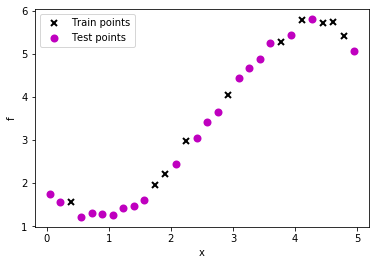

In [10]:
# lambda function, call f(x) to generate data
f = lambda x: 0.4*x**2 - 0.15*x**3 + 0.5*x**2 - 0.002*x**5 + 0.0002*x**6 +0.5*(x-2)**2

np.random.seed(0)
# 30 equally spaced sample locations 
X = np.linspace(0.05, 4.95, 30)[:,None]

np.random.shuffle(X)

# y = f(X) + epsilon
Y = f(X) + np.random.normal(0., 0.1, (30,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01

train_X = X[:10]
train_Y = Y[:10]

test_X = X[10:]
test_Y = Y[10:]

# Plot observations
plt.plot(train_X, train_Y, "kx", mew=2, label='Train points')
plt.plot(test_X, test_Y, "mo", mew=2, label='Test points')



# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend()

#### Fitting the above data usigng GPR with RBF kernel by varying the length scale (Noiseless case)


Here we assume that observations (train instances) are noise free. Thus, the GP fit must pass exactly through the train points.

In [11]:
fig, ax = plt.subplots()


ls = [0.05, 0.25, 0.5, 1., 2., 4.]
from sklearn.metrics import mean_absolute_error



def update(iteration):
    ax.cla()
    k = GPy.kern.RBF(1)
    k.lengthscale = ls[iteration]
    m = GPy.models.GPRegression(train_X, train_Y, k)
    m.Gaussian_noise = 0.0
    m.plot(ax=ax)
    ax.plot(test_X, test_Y, "mo", mew=2, label='Test points')

    ax.legend()
    ax.set_title("Length scale = %s, MAE = %s" %(k.lengthscale[0], mean_absolute_error(test_Y, m.predict_noiseless(test_X)[0].flatten())));
    fig.tight_layout()



num_iterations = len(ls)
anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations, 1), interval=500)
plt.close()

rc('animation', html='jshtml')
anim


We can see that increasing the length scale makes the fit smoother.

#### Fitting the above data usigng GPR with RBF kernel by varying the length scale (Noisy case)


Here we assume that observations (train instances) have noise. Thus, the GP fit may not pass exactly through the train points.

In [12]:
fig, ax = plt.subplots()


ls = [0.05, 0.25, 0.5, 1., 2., 4.]
from sklearn.metrics import mean_absolute_error



def update(iteration):
    ax.cla()
    k = GPy.kern.RBF(1)
    k.lengthscale = ls[iteration]
    m = GPy.models.GPRegression(train_X, train_Y, k)
    m.plot(ax=ax)
    ax.plot(test_X, test_Y, "mo", mew=2, label='Test points')

    ax.legend()
    ax.set_title("Length scale = %s, MAE = %s" %(k.lengthscale[0], mean_absolute_error(test_Y, m.predict_noiseless(test_X)[0].flatten())));
    fig.tight_layout()



num_iterations = len(ls)
anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations, 1), interval=500)
plt.close()

rc('animation', html='jshtml')
anim



### Optimizing kernel parameters

Thus far we had been hard coding the kernel parameters. Could we learn these? Yes, we can learn these by applying MLE. This might sound a little weird -- learning prior parameters from data in the Bayesian setting?!

In [13]:
k = GPy.kern.RBF(1)
m = GPy.models.GPRegression(train_X, train_Y, k)
m.optimize()

In [14]:
m

GP_regression.,value,constraints,priors
rbf.variance,12.433073229232102,+ve,
rbf.lengthscale,2.34663339745307,+ve,
Gaussian_noise.variance,0.017278356392144867,+ve,


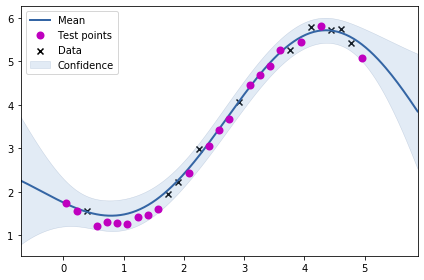

In [15]:
m.plot()
ax = plt.gca()
ax.plot(test_X, test_Y, "mo", mew=2, label='Test points')

ax.legend()

In [16]:
mean_absolute_error(test_Y, m.predict(test_X)[0].flatten())

0.1261412756644803

Above, we see the fit for the learnt kernel parameters.

### Other kernels

We have thus far discussed RBF kernel. Let us now have a quck look at Periodic kernel before we look at combining differnt kernels.

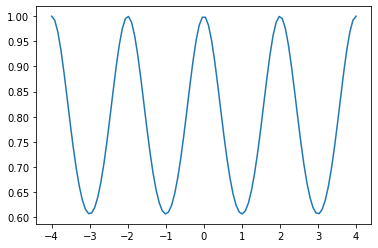

In [17]:
k = GPy.kern.StdPeriodic(1, period=2)
data = np.linspace(-4.,4.,100)[:, None]
C = k.K(data, np.array([[0.]]))

plt.plot(data,C)

The periodic kernel does what you might expect -- there is a periodic nature of relation between different points.

Let us now try to fit the periodic kernel to our previously generated data.

In [18]:
m = GPy.models.GPRegression(train_X, train_Y, k)
m.optimize()

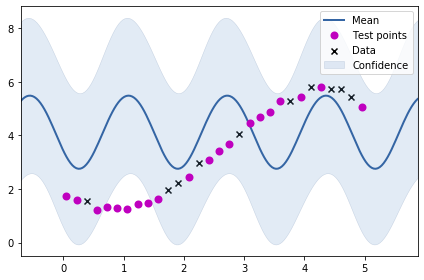

In [19]:
m.plot()
ax = plt.gca()
ax.plot(test_X, test_Y, "mo", mew=2, label='Test points')

ax.legend()

As we might have expected, the fit is not very good. Let us create a data set having periodicity where our periodic kernel would be of good value.

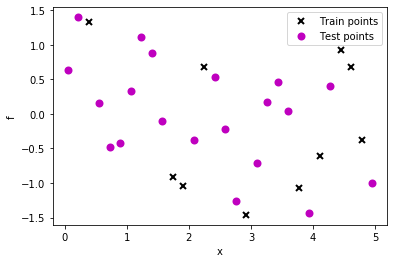

In [20]:
# lambda function, call f(x) to generate data
g = lambda x: np.sin(6*x) + 0.5*np.cos(x)

np.random.seed(0)
# 30 equally spaced sample locations 
X2 = np.linspace(0.05, 4.95, 30)[:,None]

np.random.shuffle(X2)

# y = f(X) + epsilon
Y2 = g(X2) + np.random.normal(0., 0.1, (30,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01

train_X2 = X2[:10]
train_Y2 = Y2[:10]

test_X2 = X2[10:]
test_Y2 = Y2[10:]

# Plot observations
plt.plot(train_X2, train_Y2, "kx", mew=2, label='Train points')
plt.plot(test_X2, test_Y2, "mo", mew=2, label='Test points')



# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend()

In [21]:
m = GPy.models.GPRegression(train_X2, train_Y2, k)
m.optimize()

In [22]:
m

GP_regression.,value,constraints,priors
std_periodic.variance,1.6241936960384638,+ve,
std_periodic.period,2.0498165862939817,+ve,
std_periodic.lengthscale,0.5405924861920798,+ve,
Gaussian_noise.variance,0.026138350160739007,+ve,


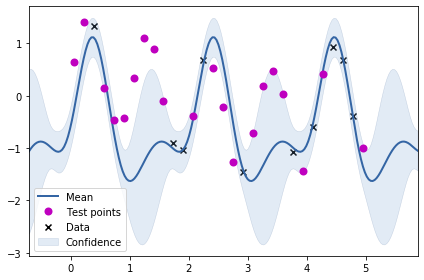

In [23]:
m.plot()
ax = plt.gca()
ax.plot(test_X2, test_Y2, "mo", mew=2, label='Test points')

ax.legend()

From the plot above, we can see that just using the periodic kernel is not very useful. Maybe we need to combine the RBF kernel with the periodic kernel? We will be trying two combinations: adding the two kernels and multiplying the two kernels to obtain two new kernels.

In [24]:
k1 = GPy.kern.StdPeriodic(1, period=2)
k2 = GPy.kern.RBF(1, lengthscale=1)
k_combined_1 = k1+k2
k_combined_2 = k1*k2

Let us now try to visualise the two kernels.

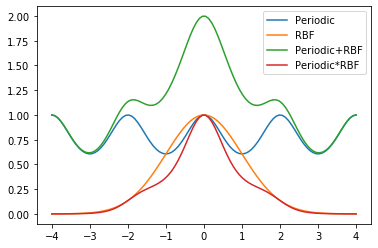

In [25]:
C1 = k_combined_1.K(data, np.array([[0.]]))
C2 = k_combined_2.K(data, np.array([[0.]]))


plt.plot(data,k1.K(data, np.array([[0.]])),label="Periodic")
plt.plot(data,k2.K(data, np.array([[0.]])),label="RBF")



plt.plot(data,C1,label="Periodic+RBF")
plt.plot(data,C2,label="Periodic*RBF")
plt.legend()

We can also visualise the covariance matrices corresponding to the two new kernels we have created.

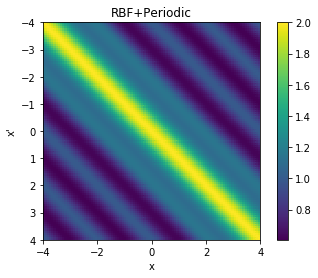

In [26]:
cov = k_combined_1.K(data,data)

# Plot the covariance of the sample space
plt.pcolor(data.T, data, cov)

# Format and annotate plot
plt.gca().invert_yaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("RBF+Periodic");

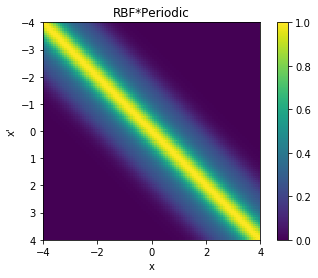

In [27]:
cov = k_combined_2.K(data,data)

# Plot the covariance of the sample space
plt.pcolor(data.T, data, cov)

# Format and annotate plot
plt.gca().invert_yaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("RBF*Periodic");

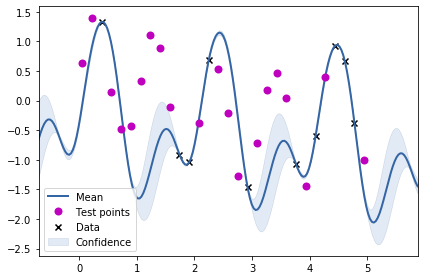

In [28]:
m = GPy.models.GPRegression(train_X2, train_Y2, k_combined_1)
m.optimize()
m.plot()
ax = plt.gca()
ax.plot(test_X2, test_Y2, "mo", mew=2, label='Test points')

ax.legend()


Name : GP regression
Objective : 4.136252889408651
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.                |                  value  |  constraints  |  priors
  mul.std_periodic.variance     |     1.7461089633948401  |      +ve      |        
  mul.std_periodic.period       |      2.041745856285753  |      +ve      |        
  mul.std_periodic.lengthscale  |     0.6637866448282967  |      +ve      |        
  mul.rbf.variance              |     1.7461089633948303  |      +ve      |        
  mul.rbf.lengthscale           |      24.98629931665634  |      +ve      |        
  Gaussian_noise.variance       |  4.955970365230769e-16  |      +ve      |        


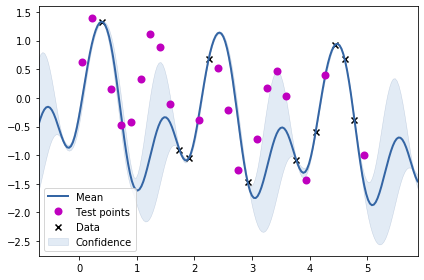

In [29]:
m = GPy.models.GPRegression(train_X2, train_Y2, k_combined_2)
m.optimize()
m.plot()
print(m)
ax = plt.gca()
ax.plot(test_X2, test_Y2, "mo", mew=2, label='Test points')

ax.legend()

From the above two visualisations, we can see the two kernels in action.

### 2D GP

Having studied GPR for 1 dimension, we will now be looking at GPR for 2d data. Let us first create some dataset.

In [30]:
X = np.array([[3, 2], [1, 4], [1, 1], [3, 4], [2,2], [2, 3], [3, 1], [3, 3.5], [2.5, 3.5]])
y = np.array([1, 1, 3, 2, 5.5, 4.5, 0.5, 3, 3.5])

In [31]:
X.shape, y.shape

((9, 2), (9,))

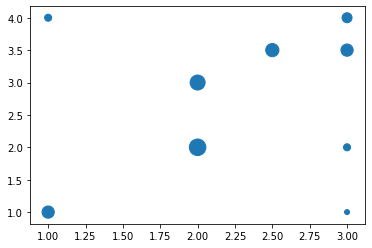

In [32]:
plt.scatter(X[:,0], X[:, 1],s=y*50)

The above visualisation shows the dataset where the size of the marker denotes the value at that location. We will now be fitting a RBF kernel (expecting a 2d input) to this data set.

In [33]:
k_2d = GPy.kern.RBF(input_dim=2, lengthscale=1)

In [34]:
X.shape

(9, 2)

In [35]:
m = GPy.models.GPRegression(X, y.reshape(-1, 1), k_2d)
m.optimize()

Generating predictions over the entire grid for visualisation.

In [36]:
x_t = np.linspace(0, 4.5, 40)
y_t = np.linspace(0, 4.5, 40)

XX, YY = np.meshgrid(x_t, y_t)

In [37]:
Z_pred = np.zeros_like(YY)
for i in range(40):
    for j in range(40):
        Z_pred[i, j] = m.predict(np.array([XX[i, j], YY[i, j]]).reshape(1, 2))[0]

In [38]:
Z_pred.shape

(40, 40)

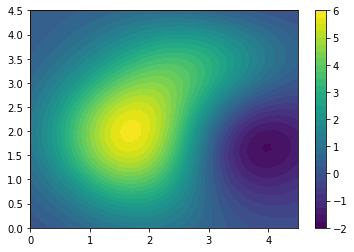

In [39]:
plt.contourf(XX, YY, Z_pred, levels=30)
plt.colorbar()

The above plot shows the prediction in the 2d space. We can alternatively view the 3d surface plot.

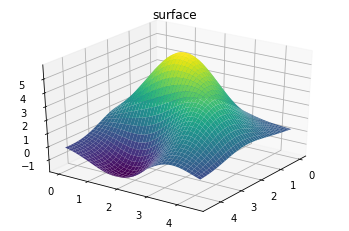

In [40]:
ax = plt.axes(projection='3d')
ax.plot_surface(XX, YY, Z_pred, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');
ax.view_init(30, 35)

In [41]:
Z_var = np.zeros_like(YY)
for i in range(40):
    for j in range(40):
        Z_var[i, j] = m.predict(np.array([XX[i, j], YY[i, j]]).reshape(1, 2))[1]

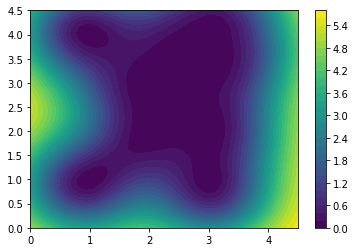

In [42]:
plt.contourf(XX, YY, Z_var, levels=30)
plt.colorbar()

We can above see the variance plot.

## Air quality 2d map 

Now, we will be using GPs for predicting air quality in New Delhi. See my [previous post]() on how to get AQ data for Delhi.https://nipunbatra.github.io/blog/air%20quality/2018/06/21/aq-india-map.html

I will be creating a function to visualise the AQ estimations using GPs based on different kernels.

The shapefile for Delhi can be downloaded from [here](https://www.arcgis.com/home/item.html?id=165e7c8ae6744dd5ad04537c6f938ffd).

In [53]:
import pandas as pd
import os
df = pd.read_csv(os.path.expanduser("~/Downloads/2018-04-06.csv"))
df = df[(df.country=='IN')&(df.city=='Delhi')&(df.parameter=='pm25')].dropna().groupby("location").mean()

In [54]:
df

,value,latitude,longitude
location,,,
"Burari Crossing, New Delhi - IMD",245.583333,28.725650,77.201157
"CRRI Mathura Road, New Delhi - IMD",265.666667,28.551200,77.273574
"DTU, New Delhi - CPCB",214.333333,28.750050,77.111261
"IGI Airport Terminal - 3, New Delhi - IMD",130.666667,28.562776,77.118005
"IHBAS, Dilshad Garden,New Delhi - CPCB",212.583333,28.680275,77.201157
"ITO, New Delhi - CPCB",220.500000,28.631694,77.249439
"Lodhi Road, New Delhi - IMD",176.083333,28.591825,77.227307
"Mandir Marg, New Delhi - DPCC",82.000000,28.637269,77.200560
"NSIT Dwarka, New Delhi - CPCB",184.583333,28.609090,77.032541


In [55]:
import geopandas
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))

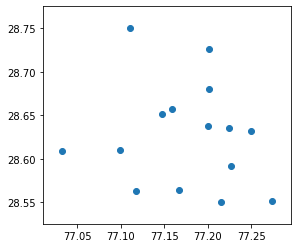

In [56]:
gdf.plot()

In [57]:
def plot_air_vis(df, k, shp, title):
    m = GPy.models.GPRegression(df[['longitude','latitude']], df[['value']], k)
    m.optimize(max_iters=2000)
    y_t = np.linspace(28.38,28.9, 40)
    x_t = np.linspace(76.82, 77.4, 40)

    XX, YY = np.meshgrid(x_t, y_t)
    Z_pred = np.zeros_like(YY)
    Z_var = np.zeros_like(YY)
    for i in range(40):
        for j in range(40):
            Z_pred[i, j], Z_var[i, j] = m.predict_noiseless(np.array([XX[i, j], YY[i, j]]).reshape(1, 2))
    
    data = geopandas.read_file(fp)
    fig = plt.figure(figsize=(6, 6))
    plt.contourf(XX, YY, Z_pred, levels=30,alpha=0.6,cmap='Purples')
    plt.colorbar()
    gdf.plot(ax=plt.gca(),markersize=gdf['value'],color='k')
    data.plot(color='k',ax=plt.gca(),zorder=-1,alpha=0.4)
    plt.gca().set_aspect("equal")
    for a in [100, 150, 200,250]:
        plt.scatter([], [], c='k', alpha=1, s=a,
                    label=str(a) + '$\mu g/m^3$')
    plt.legend(scatterpoints=1, frameon=True,
               labelspacing=1, loc='upper left',ncol=2)
    
    plt.title(title+"\t"+str(m.objective_function()))

In [58]:
k_2d = GPy.kern.RBF(input_dim=2, lengthscale=1)
k_2d_rbf_2 = GPy.kern.RBF(input_dim=2, lengthscale=3)*k_2d
k_2d_rbf_3 = GPy.kern.RBF(input_dim=2, lengthscale=3) + k_2d_rbf_2
k_matern32 = GPy.kern.Matern32(input_dim=2)
k_matern52 = GPy.kern.Matern52(input_dim=2)

k_rbf_matern = k_matern32 * k_matern52 + k_matern32*k_2d_rbf_3


fp=os.path.expanduser("~/Downloads/wards delimited.shp")

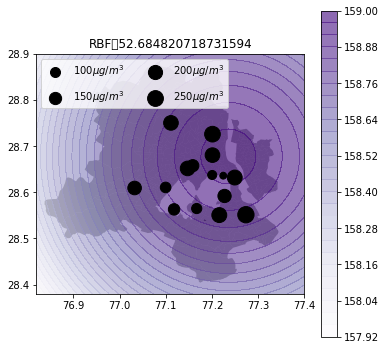

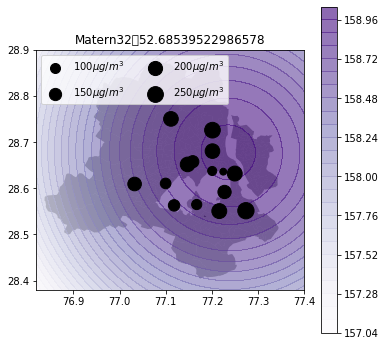

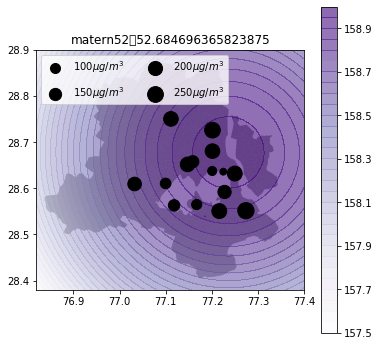

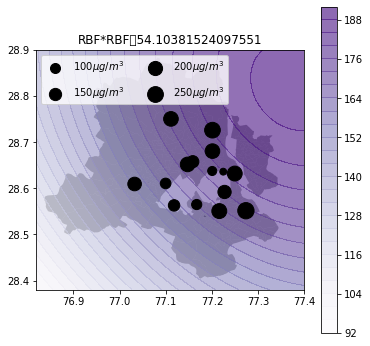

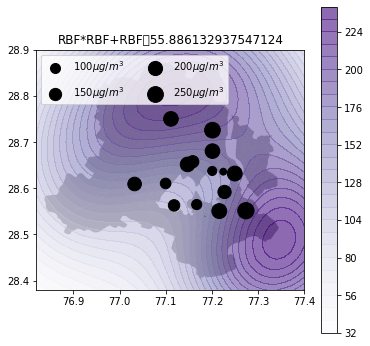

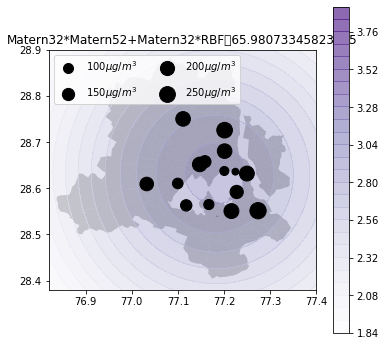

In [59]:
plot_air_vis(df, k_2d, fp,"RBF")
plot_air_vis(df, k_matern32, fp,"Matern32")
plot_air_vis(df, k_matern52, fp,"matern52")
plot_air_vis(df, k_2d_rbf_2, fp,"RBF*RBF")
plot_air_vis(df, k_2d_rbf_3, fp,"RBF*RBF+RBF")
plot_air_vis(df, k_rbf_matern, fp,"Matern32*Matern52+Matern32*RBF")

There you go. Till next time!